# Inferencing pre-trained ViT model on ImageNet-1k

In [1]:
!nvidia-smi

Sat Dec  9 17:40:55 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 510.47.03    Driver Version: 510.47.03    CUDA Version: 11.6     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA RTX A6000    On   | 00000000:86:00.0 Off |                  Off |
| 30%   41C    P8    32W / 300W |      5MiB / 49140MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
|   1  NVIDIA RTX A6000    On   | 00000000:AF:00.0 Off |                  Off |
| 30%   

In [1]:
import torch
from torch.nn.functional import softmax
from custom_vision_transformer import VisionTransformer
from Utils.preprocessing import ImageNet
import timm

import os
os.environ['XDG_CACHE_HOME'] = '/space/hotel/taile/model_exploration/Model'

In [69]:
def get_n_params(module):
    return sum(p.numel() for p in module.parameters() if p.requires_grad)

def assert_tensor_equal(t1, t2):
    a1, a2 = t1.detach().numpy(), t2.detach().numpy()
    np.testing.assert_allclose(a1, a2)

model_name = "vit_base_patch16_384"
official_model = timm.create_model(model_name, pretrained=True)
official_model.eval()
print(type(official_model))

base_vit_custom_config = {
    "img_size": 384,
    "in_chans": 3,
    "patch_size": 16,
    "embed_dim": 768,
    "depth": 12,
    "num_heads": 12,
    "qkv_bias": True,
    "mlp_ratio": 4.0
}

custom_model = VisionTransformer(**base_vit_custom_config)
custom_model.eval()

for (name_official, param_official), (name_custom, param_custom) in zip(official_model.named_parameters(), custom_model.named_parameters()):
    assert param_official.numel() == param_custom.numel() 
    print(f"{name_official} | {name_custom}")

    param_custom.data[:] = param_official.data

    assert_tensor_equal(param_custom.data, param_official.data)

input_ = torch.rand(1, 3, 384, 384)
output_custom = custom_model(input_)
output_official = official_model(input_)

assert get_n_params(custom_model) == get_n_params(official_model)
assert_tensor_equal(output_custom, output_official)

torch.save(custom_model, "./Model/vit_base_patch16_384_custom.pth")

<class 'timm.models.vision_transformer.VisionTransformer'>
cls_token | cls_token
pos_embed | pos_embed
patch_embed.proj.weight | patch_embed.proj.weight
patch_embed.proj.bias | patch_embed.proj.bias
blocks.0.norm1.weight | blocks.0.norm1.weight
blocks.0.norm1.bias | blocks.0.norm1.bias
blocks.0.attn.qkv.weight | blocks.0.attn.qkv.weight
blocks.0.attn.qkv.bias | blocks.0.attn.qkv.bias
blocks.0.attn.proj.weight | blocks.0.attn.proj.weight
blocks.0.attn.proj.bias | blocks.0.attn.proj.bias
blocks.0.norm2.weight | blocks.0.norm2.weight
blocks.0.norm2.bias | blocks.0.norm2.bias
blocks.0.mlp.fc1.weight | blocks.0.mlp.fc1.weight
blocks.0.mlp.fc1.bias | blocks.0.mlp.fc1.bias
blocks.0.mlp.fc2.weight | blocks.0.mlp.fc2.weight
blocks.0.mlp.fc2.bias | blocks.0.mlp.fc2.bias
blocks.1.norm1.weight | blocks.1.norm1.weight
blocks.1.norm1.bias | blocks.1.norm1.bias
blocks.1.attn.qkv.weight | blocks.1.attn.qkv.weight
blocks.1.attn.qkv.bias | blocks.1.attn.qkv.bias
blocks.1.attn.proj.weight | blocks.1.attn

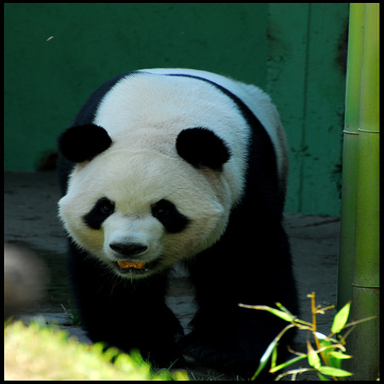

Prediction: giant panda, panda, panda bear, coon bear, Ailuropoda melanoleuca (99.89%) - Label: giant panda, panda, panda bear, coon bear, Ailuropoda melanoleuca


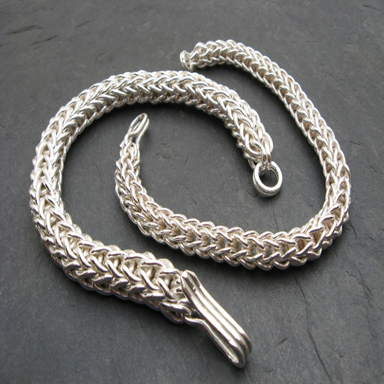

Prediction: chain (70.82%) - Label: chain mail, ring mail, mail, chain armor, chain armour, ring armor, ring armour


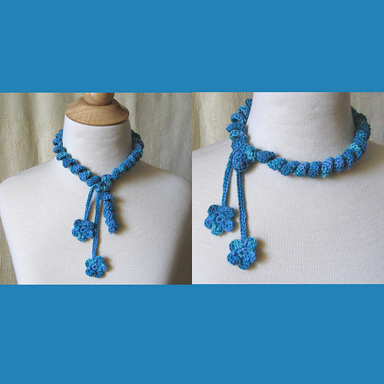

Prediction: necklace (96.79%) - Label: necklace


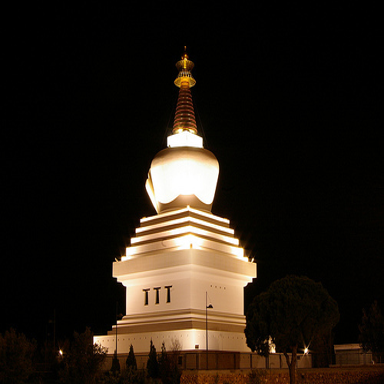

Prediction: stupa, tope (99.93%) - Label: stupa, tope


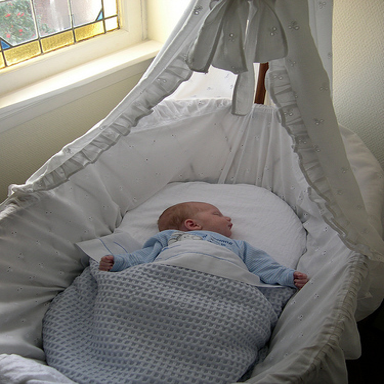

Prediction: cradle (92.85%) - Label: cradle


In [74]:
ViT = VisionTransformer().load_model("./Model/vit_base_patch16_384_custom.pth")
device = torch.device("cuda:0")
ViT.to(device=device)
ViT.eval()
# Initializing dataloader
dataloader = ImageNet("/space/data/imagenet/val", 5)
classes = dict(enumerate(open("./Utils/classes.txt")))

for _ in range(5):
    im, im_tensor, label = next(dataloader.dataset)

    # Inference model
    logits = ViT(im_tensor.to(device=device))
    probs = softmax(logits, dim=-1)

    top_probs, top_ixs = probs[0].topk(1)
    prob, idx = top_probs.item(), top_ixs.item()

    cls = classes[idx].strip().replace("_", " ")
    
    display(im)
    print(f"Prediction: {cls} ({(prob*100):.2f}%) - Label: {label}")

# Fine-tuning pre-trained ViT model on different datasets

In [5]:
from PIL import Image
from torchvision.datasets import Flowers102, Country211, OxfordIIITPet
from torchvision.models import ViT_B_16_Weights

## Fine-tuning model on Food-101 dataset

In [48]:
!python train.py    --data_dir ./dataset \
                    --dataset_name food-101 \
                    --pretrained \
                    --model_dir ./Model/vit_base_patch16_384_custom.pth \
                    --epochs 10 \
                    --batch_sz 512 \
                    --device cuda:0 \
                    --verbose \
                    --save_dir ./fine_tuning_results 

Load dataset.
Load pre-trained model.


Layer (type:depth-idx)                   Input Shape               Output Shape              Param #
├─PatchEmbed: 1-1                        [-1, 3, 384, 384]         [-1, 576, 768]            --
|    └─Conv2d: 2-1                       [-1, 3, 384, 384]         [-1, 768, 24, 24]         (590,592)
├─Dropout: 1-2                           [-1, 577, 768]            [-1, 577, 768]            --
├─ModuleList: 1                          []                        []                        --
|    └─Transformer: 2-2                  [-1, 577, 768]            [-1, 577, 768]            --
|    |    └─LayerNorm: 3-1               [-1, 577, 768]            [-1, 577, 768]            (1,536)
|    |    └─Attention: 3-2               [-1, 577, 768]            [-1, 577, 768]            (2,362,368)
|    |    └─LayerNorm: 3-3               [-1, 577, 768]            [-1, 577, 768]            (1,536)
|    |    └─MLP: 3-4                     [-1, 577, 768]            [-1, 577, 768]            (4,722,432)


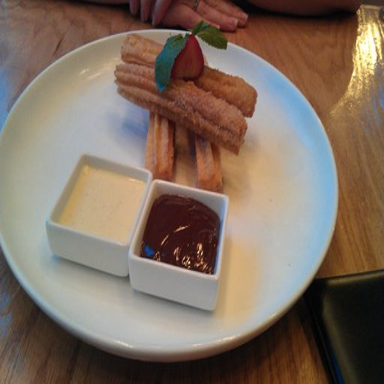

Load model.
Start inferencing.
Prediction: churros (84.10%)


In [32]:
im = Image.open("./dataset/food-101/images/churros/1148015.jpg")
im = im.resize((384, 384))
display(im)

# Inference
!python inference.py    --img ./dataset/food-101/images/churros/1148015.jpg \
                        --qkv_bias \
                        --cls_dir ./dataset/food-101/meta/classes.txt \
                        --pretrained \
                        --checkpoint_dir ./fine_tuning_results/food-101_model_1.pth \
                        --device cuda:0 \
                        --verbose

In [83]:
!python train.py    --data_dir ./dataset \
                    --dataset_name food-101 \
                    --pretrained \
                    --checkpoint_dir ./fine_tuning_results/food-101_model_1.pth \
                    --keep_head \
                    --qkv_bias \
                    --epochs 4 \
                    --lr 1e-2 \
                    --batch_sz 512 \
                    --device cuda:0 \
                    --verbose \
                    --save_dir ./fine_tuning_results 

Load dataset.
Load pre-trained model.
Layer (type:depth-idx)                   Input Shape               Output Shape              Param #
├─PatchEmbed: 1-1                        [-1, 3, 384, 384]         [-1, 576, 768]            --
|    └─Conv2d: 2-1                       [-1, 3, 384, 384]         [-1, 768, 24, 24]         (590,592)
├─Dropout: 1-2                           [-1, 577, 768]            [-1, 577, 768]            --
├─ModuleList: 1                          []                        []                        --
|    └─Transformer: 2-2                  [-1, 577, 768]            [-1, 577, 768]            --
|    |    └─LayerNorm: 3-1               [-1, 577, 768]            [-1, 577, 768]            (1,536)
|    |    └─Attention: 3-2               [-1, 577, 768]            [-1, 577, 768]            (2,362,368)
|    |    └─LayerNorm: 3-3               [-1, 577, 768]            [-1, 577, 768]            (1,536)
|    |    └─MLP: 3-4                     [-1, 577, 768]            

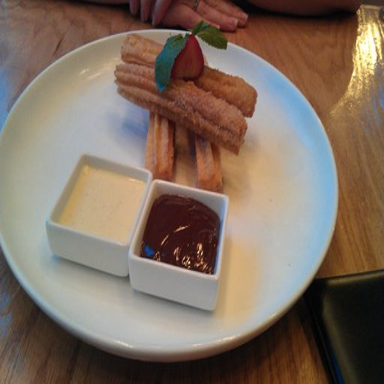

Load model.
Start inferencing.
Prediction: churros (99.27%)


In [5]:
im = Image.open("./dataset/food-101/images/churros/1148015.jpg")
im = im.resize((384, 384))
display(im)

# Inference
!python inference.py    --img ./dataset/food-101/images/churros/1148015.jpg \
                        --qkv_bias \
                        --cls_dir ./dataset/food-101/meta/classes.txt \
                        --pretrained \
                        --checkpoint_dir ./fine_tuning_results/food-101_model_2.pth \
                        --device cuda:0 \
                        --verbose

## Fine-tuning model on Flowers-102 dataset

In [50]:
!python train.py    --data_dir ./dataset \
                    --dataset_name flowers-102 \
                    --pretrained \
                    --model_dir ./Model/vit_base_patch16_384_custom.pth \
                    --epochs 50 \
                    --batch_sz 512 \
                    --device cuda:0 \
                    --verbose \
                    --save_dir ./fine_tuning_results 

Load dataset.
Load pre-trained model.
Layer (type:depth-idx)                   Input Shape               Output Shape              Param #
├─PatchEmbed: 1-1                        [-1, 3, 384, 384]         [-1, 576, 768]            --
|    └─Conv2d: 2-1                       [-1, 3, 384, 384]         [-1, 768, 24, 24]         (590,592)
├─Dropout: 1-2                           [-1, 577, 768]            [-1, 577, 768]            --
├─ModuleList: 1                          []                        []                        --
|    └─Transformer: 2-2                  [-1, 577, 768]            [-1, 577, 768]            --
|    |    └─LayerNorm: 3-1               [-1, 577, 768]            [-1, 577, 768]            (1,536)
|    |    └─Attention: 3-2               [-1, 577, 768]            [-1, 577, 768]            (2,362,368)
|    |    └─LayerNorm: 3-3               [-1, 577, 768]            [-1, 577, 768]            (1,536)
|    |    └─MLP: 3-4                     [-1, 577, 768]            

In [11]:
pretrained_weight = ViT_B_16_Weights.IMAGENET1K_SWAG_E2E_V1
vit_transforms = pretrained_weight.transforms()
test_dataset = Flowers102(root="./dataset", split="test", transform=vit_transforms, download=True)
print(str(test_dataset._image_files[1000]))

dataset/flowers-102/jpg/image_05254.jpg


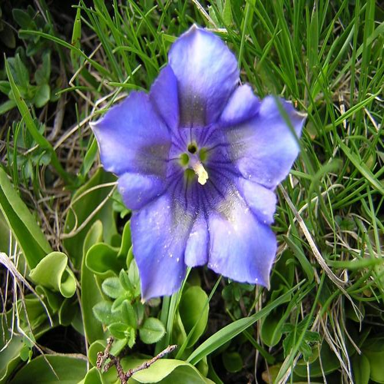

Prediction: 27 (15.00%)
Label: 27


In [31]:
im = Image.open("./dataset/flowers-102/jpg/image_05254.jpg")
im = im.resize((384, 384))
display(im)

# Inference
!python inference.py    --img ./dataset/flowers-102/jpg/image_05254.jpg \
                        --qkv_bias \
                        --dataset_name flowers-102 \
                        --pretrained \
                        --checkpoint_dir ./fine_tuning_results/flowers-102_model_1.pth \
                        --device cuda:0

print(f"Label: {test_dataset._labels[1000]}")

In [75]:
!python train.py    --data_dir ./dataset \
                    --dataset_name flowers-102 \
                    --pretrained \
                    --checkpoint_dir ./fine_tuning_results/flowers-102_model_1.pth \
                    --keep_head \
                    --qkv_bias \
                    --epochs 12 \
                    --lr 1e-2 \
                    --batch_sz 512 \
                    --device cuda:0 \
                    --verbose \
                    --save_dir ./fine_tuning_results 

Load dataset.
Load pre-trained model.
Layer (type:depth-idx)                   Input Shape               Output Shape              Param #
├─PatchEmbed: 1-1                        [-1, 3, 384, 384]         [-1, 576, 768]            --
|    └─Conv2d: 2-1                       [-1, 3, 384, 384]         [-1, 768, 24, 24]         (590,592)
├─Dropout: 1-2                           [-1, 577, 768]            [-1, 577, 768]            --
├─ModuleList: 1                          []                        []                        --
|    └─Transformer: 2-2                  [-1, 577, 768]            [-1, 577, 768]            --
|    |    └─LayerNorm: 3-1               [-1, 577, 768]            [-1, 577, 768]            (1,536)
|    |    └─Attention: 3-2               [-1, 577, 768]            [-1, 577, 768]            (2,362,368)
|    |    └─LayerNorm: 3-3               [-1, 577, 768]            [-1, 577, 768]            (1,536)
|    |    └─MLP: 3-4                     [-1, 577, 768]            

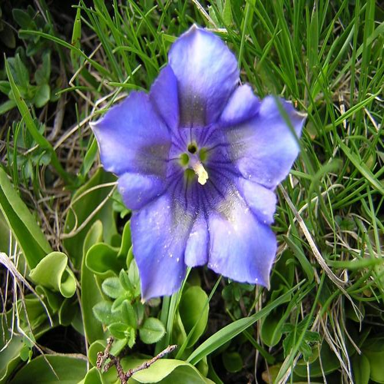

Prediction: 27 (64.25%)
Label: 27


In [30]:
im = Image.open("./dataset/flowers-102/jpg/image_05254.jpg")
im = im.resize((384, 384))
display(im)

# Inference
!python inference.py    --img ./dataset/flowers-102/jpg/image_05254.jpg \
                        --qkv_bias \
                        --dataset_name flowers-102 \
                        --pretrained \
                        --checkpoint_dir ./fine_tuning_results/flowers-102_model_2.pth \
                        --device cuda:0

print(f"Label: {test_dataset._labels[1000]}")

## Fine-tuning model on PCAM dataset

In [8]:
!python train.py    --data_dir ./dataset \
                    --dataset_name pcam-2 \
                    --pretrained \
                    --model_dir ./Model/vit_base_patch16_384_custom.pth \
                    --epochs 1 \
                    --batch_sz 512 \
                    --device cuda:0 \
                    --verbose \
                    --save_dir ./fine_tuning_results 

Load dataset.
Load pre-trained model.
Layer (type:depth-idx)                   Input Shape               Output Shape              Param #
├─PatchEmbed: 1-1                        [-1, 3, 384, 384]         [-1, 576, 768]            --
|    └─Conv2d: 2-1                       [-1, 3, 384, 384]         [-1, 768, 24, 24]         (590,592)
├─Dropout: 1-2                           [-1, 577, 768]            [-1, 577, 768]            --
├─ModuleList: 1                          []                        []                        --
|    └─Transformer: 2-2                  [-1, 577, 768]            [-1, 577, 768]            --
|    |    └─LayerNorm: 3-1               [-1, 577, 768]            [-1, 577, 768]            (1,536)
|    |    └─Attention: 3-2               [-1, 577, 768]            [-1, 577, 768]            (2,362,368)
|    |    └─LayerNorm: 3-3               [-1, 577, 768]            [-1, 577, 768]            (1,536)
|    |    └─MLP: 3-4                     [-1, 577, 768]            

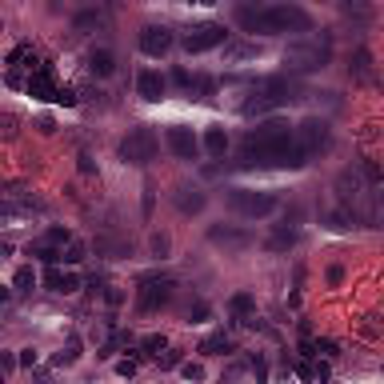

Prediction: 1 (80.14%)
Label: 1


In [12]:
with h5py.File('./dataset/pcam/camelyonpatch_level_2_split_test_x.h5', 'r') as hdf_file:
    images = hdf_file['x'][:]
    im = Image.fromarray(images[100])
    im = im.resize((384, 384))
    display(im)

# Inference
!python inference.py    --img ./dataset/pcam/camelyonpatch_level_2_split_test_x.h5 \
                        --img_id 100 \
                        --qkv_bias \
                        --dataset_name pcam-2 \
                        --dataset_type h5 \
                        --pretrained \
                        --checkpoint_dir ./fine_tuning_results/pcam-2_model_1.pth \
                        --device cuda:0

with h5py.File('./dataset/pcam/camelyonpatch_level_2_split_test_y.h5', 'r') as hdf_file:
    labels = hdf_file['y'][:]
    label = labels[100, 0, 0, 0]
print(f"Label: {label}")

In [14]:
!python train.py    --data_dir ./dataset \
                    --dataset_name pcam-2 \
                    --pretrained \
                    --checkpoint_dir ./fine_tuning_results/pcam-2_model_1.pth \
                    --keep_head \
                    --qkv_bias \
                    --epochs 1 \
                    --lr 1e-2 \
                    --batch_sz 512 \
                    --device cuda:0 \
                    --num_threads 4 \
                    --verbose \
                    --save_dir ./fine_tuning_results 

Load dataset.
Load pre-trained model.
Layer (type:depth-idx)                   Input Shape               Output Shape              Param #
├─PatchEmbed: 1-1                        [-1, 3, 384, 384]         [-1, 576, 768]            --
|    └─Conv2d: 2-1                       [-1, 3, 384, 384]         [-1, 768, 24, 24]         (590,592)
├─Dropout: 1-2                           [-1, 577, 768]            [-1, 577, 768]            --
├─ModuleList: 1                          []                        []                        --
|    └─Transformer: 2-2                  [-1, 577, 768]            [-1, 577, 768]            --
|    |    └─LayerNorm: 3-1               [-1, 577, 768]            [-1, 577, 768]            (1,536)
|    |    └─Attention: 3-2               [-1, 577, 768]            [-1, 577, 768]            (2,362,368)
|    |    └─LayerNorm: 3-3               [-1, 577, 768]            [-1, 577, 768]            (1,536)
|    |    └─MLP: 3-4                     [-1, 577, 768]            

Epoch 0/0:	[===================================]	- 4s 852ms/it	- Loss: 0.263


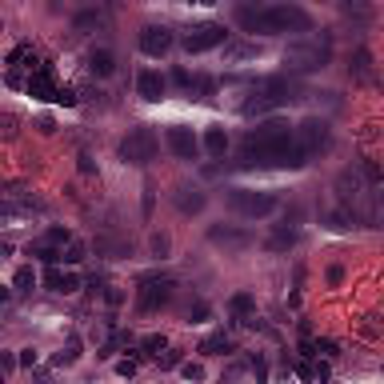

Prediction: 1 (95.80%)
Label: 1


In [15]:
with h5py.File('./dataset/pcam/camelyonpatch_level_2_split_test_x.h5', 'r') as hdf_file:
    images = hdf_file['x'][:]
    im = Image.fromarray(images[100])
    im = im.resize((384, 384))
    display(im)

# Inference
!python inference.py    --img ./dataset/pcam/camelyonpatch_level_2_split_test_x.h5 \
                        --img_id 100 \
                        --qkv_bias \
                        --dataset_name pcam-2 \
                        --dataset_type h5 \
                        --pretrained \
                        --checkpoint_dir ./fine_tuning_results/pcam-2_model_2.pth \
                        --device cuda:0

with h5py.File('./dataset/pcam/camelyonpatch_level_2_split_test_y.h5', 'r') as hdf_file:
    labels = hdf_file['y'][:]
    label = labels[100, 0, 0, 0]
print(f"Label: {label}")

## Fine-tuning model on Country211 dataset

In [1]:
!python train.py    --data_dir ./dataset \
                    --dataset_name country-211 \
                    --pretrained \
                    --model_dir ./Model/vit_base_patch16_384_custom.pth \
                    --opt adam \
                    --epochs 10 \
                    --batch_sz 512 \
                    --device cuda:0 \
                    --num_threads 4 \
                    --verbose \
                    --save_dir ./fine_tuning_results 

Load dataset.
Load pre-trained model.
Layer (type:depth-idx)                   Input Shape               Output Shape              Param #
├─PatchEmbed: 1-1                        [-1, 3, 384, 384]         [-1, 576, 768]            --
|    └─Conv2d: 2-1                       [-1, 3, 384, 384]         [-1, 768, 24, 24]         (590,592)
├─Dropout: 1-2                           [-1, 577, 768]            [-1, 577, 768]            --
├─ModuleList: 1                          []                        []                        --
|    └─Transformer: 2-2                  [-1, 577, 768]            [-1, 577, 768]            --
|    |    └─LayerNorm: 3-1               [-1, 577, 768]            [-1, 577, 768]            (1,536)
|    |    └─Attention: 3-2               [-1, 577, 768]            [-1, 577, 768]            (2,362,368)
|    |    └─LayerNorm: 3-3               [-1, 577, 768]            [-1, 577, 768]            (1,536)
|    |    └─MLP: 3-4                     [-1, 577, 768]            

In [19]:
pretrained_weight = ViT_B_16_Weights.IMAGENET1K_SWAG_E2E_V1
vit_transforms = pretrained_weight.transforms()
test_dataset = Country211(root="./dataset", split="test", transform=vit_transforms, download=True)
img_path = test_dataset.imgs[200][0]
print(img_path)

dataset/country211/test/AF/1161716_34.527489_69.182195.jpg


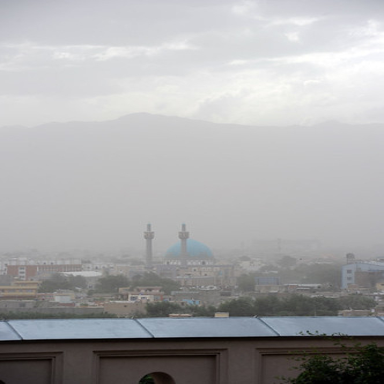

Prediction: OM (54.65%)
Label: AF


In [13]:
im = Image.open("./dataset/country211/test/AF/1161716_34.527489_69.182195.jpg")
im = im.resize((384, 384))
display(im)

# Inference
!python inference.py    --img ./dataset/country211/test/AF/1161716_34.527489_69.182195.jpg \
                        --data_dir ./dataset \
                        --dataset_name country-211 \
                        --pretrained \
                        --checkpoint_dir ./fine_tuning_results/country-211_model_1.pth \
                        --qkv_bias \
                        --device cuda:0

label = test_dataset.imgs[200][1]
print(f"Label: {test_dataset.classes[label]}")

In [24]:
!python train.py    --data_dir ./dataset \
                    --dataset_name country-211 \
                    --pretrained \
                    --checkpoint_dir ./fine_tuning_results/country-211_model_1.pth \
                    --keep_head \
                    --qkv_bias \
                    --opt adam \
                    --epochs 10 \
                    --lr 1e-2 \
                    --batch_sz 512 \
                    --device cuda:0 \
                    --num_threads 4 \
                    --verbose \
                    --save_dir ./fine_tuning_results 

Load dataset.
Load pre-trained model.


Layer (type:depth-idx)                   Input Shape               Output Shape              Param #
├─PatchEmbed: 1-1                        [-1, 3, 384, 384]         [-1, 576, 768]            --
|    └─Conv2d: 2-1                       [-1, 3, 384, 384]         [-1, 768, 24, 24]         (590,592)
├─Dropout: 1-2                           [-1, 577, 768]            [-1, 577, 768]            --
├─ModuleList: 1                          []                        []                        --
|    └─Transformer: 2-2                  [-1, 577, 768]            [-1, 577, 768]            --
|    |    └─LayerNorm: 3-1               [-1, 577, 768]            [-1, 577, 768]            (1,536)
|    |    └─Attention: 3-2               [-1, 577, 768]            [-1, 577, 768]            (2,362,368)
|    |    └─LayerNorm: 3-3               [-1, 577, 768]            [-1, 577, 768]            (1,536)
|    |    └─MLP: 3-4                     [-1, 577, 768]            [-1, 577, 768]            (4,722,432)


In [20]:
# Inference
!python inference.py    --img ./dataset/country211/test/AF/1161716_34.527489_69.182195.jpg \
                        --data_dir ./dataset \
                        --dataset_name country-211 \
                        --pretrained \
                        --checkpoint_dir ./fine_tuning_results/country-211_model_2.pth \
                        --qkv_bias \
                        --device cuda:0

label = test_dataset.imgs[200][1]
print(f"Label: {test_dataset.classes[label]}")

Prediction: IR (30.08%)
Label: AF


## Fine-tuning model on OxfordIIITPet dataset

In [25]:
!python train.py    --data_dir ./dataset \
                    --dataset_name oxfordiiipet-37 \
                    --pretrained \
                    --model_dir ./Model/vit_base_patch16_384_custom.pth \
                    --opt adam \
                    --epochs 10 \
                    --batch_sz 512 \
                    --device cuda:0 \
                    --num_threads 4 \
                    --verbose \
                    --save_dir ./fine_tuning_results 

Load dataset.
Load pre-trained model.
Layer (type:depth-idx)                   Input Shape               Output Shape              Param #
├─PatchEmbed: 1-1                        [-1, 3, 384, 384]         [-1, 576, 768]            --
|    └─Conv2d: 2-1                       [-1, 3, 384, 384]         [-1, 768, 24, 24]         (590,592)
├─Dropout: 1-2                           [-1, 577, 768]            [-1, 577, 768]            --
├─ModuleList: 1                          []                        []                        --
|    └─Transformer: 2-2                  [-1, 577, 768]            [-1, 577, 768]            --
|    |    └─LayerNorm: 3-1               [-1, 577, 768]            [-1, 577, 768]            (1,536)
|    |    └─Attention: 3-2               [-1, 577, 768]            [-1, 577, 768]            (2,362,368)
|    |    └─LayerNorm: 3-3               [-1, 577, 768]            [-1, 577, 768]            (1,536)
|    |    └─MLP: 3-4                     [-1, 577, 768]            

In [26]:
pretrained_weight = ViT_B_16_Weights.IMAGENET1K_SWAG_E2E_V1
vit_transforms = pretrained_weight.transforms()
test_dataset = OxfordIIITPet(root="./dataset", split="test", transform=vit_transforms, download=True)
img_path = str(test_dataset._images[100])
print(img_path)

dataset/oxford-iiit-pet/images/american_bulldog_207.jpg


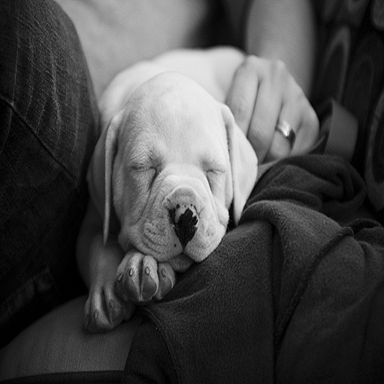

Prediction: American Bulldog (84.38%)
Label: American Bulldog


In [29]:
im = Image.open("./dataset/oxford-iiit-pet/images/american_bulldog_207.jpg")
im = im.resize((384, 384))
display(im)

# Inference
!python inference.py    --img ./dataset/oxford-iiit-pet/images/american_bulldog_207.jpg \
                        --data_dir ./dataset \
                        --dataset_name oxfordiiipet-37 \
                        --pretrained \
                        --checkpoint_dir ./fine_tuning_results/oxfordiiipet-37_model.pth \
                        --qkv_bias \
                        --device cuda:0

label = test_dataset._labels[100]
print(f"Label: {test_dataset.classes[label]}")